In [2]:
!pip install -q tensorflow_addons

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf 
import keras 
from tensorflow.keras import layers
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt 

In [4]:
(x_train , y_train) , (x_test , y_test) =  keras.datasets.cifar10.load_data()
print(f'x_train shape {x_train.shape} , y_train shape {y_train.shape} ') # 50,000 samples 
print(f'x_test shape {x_test.shape} , y_test shape {y_test.shape} ') # 10,000 samples

x_train shape (50000, 32, 32, 3) , y_train shape (50000, 1) 
x_test shape (10000, 32, 32, 3) , y_test shape (10000, 1) 


In [5]:
# Hyper-Parameters # 
# ===================== # 
num_classes = 10  
input_shape = (32 , 32 ,3 ) # h ,w ,c
learning_rate = 0.001 
weight_decay = 0.0001
batch_size = 256
n_epochs = 40 
n_patches = 144
image_size = 72 # resize the input image 
patch_size = 6 # Size of the patches to be extracted from input images 
num_heads = 8 # attention heads 
projection_dim  = 64 # ideally 256 
transformer_units = [ # represents transformer lyaer in terms of dimensions 
    projection_dim*2 ,
    projection_dim
] 
transformer_layers = 8 # 8 encoders and 8 decoders 
mlp_head_units = [2048 , 1024] #size of dense layers of the classifier 


# ====================== # 

In [6]:
data_augmentation = keras.Sequential(
                        [
                            layers.Normalization(), # (x - mean(x)) / var(x)  
                            layers.Resizing(image_size , image_size)  ,
                            layers.RandomFlip('horizontal') , 
                            layers.RandomRotation(factor=0.02) ,
                            layers.RandomZoom(height_factor=0.2,width_factor=0.2)
                        ],
                        name = 'data_augmenter'
                    )
data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x , hidden_units , dropout_rate) :
    for unit in hidden_units : 
        x = layers.Dense(units = unit , activation = tf.nn.gelu)(x) 
        # GeLU - Gaussian Error Linear Unit || GeLU does well in nlp but is computationally costly 
        x = layers.Dropout(dropout_rate)(x)
    return x 

In [8]:
class CreatePatches(layers.Layer):
    def __init__(self , patch_size ) :
        super(CreatePatches , self ).__init__()
        self.patch_size = patch_size 
        
    def call(self , inputs):
        batch_size = tf.shape(inputs)[0]
        patches = tf.image.extract_patches(
            images = inputs , # input images 
            sizes = [1 , self.patch_size , self.patch_size ,1 ] ,
            strides =  [1 , self.patch_size , self.patch_size ,1 ] ,
            rates = [1,1,1,1] , # 1 means no dilation 
            padding = 'VALID' # if the shapes is short pad the patches 
        )
        patch_dims = patches.shape[-1] 
        patches = tf.reshape(patches , [batch_size , -1 , patch_dims] ) 
        return patches 
        

Image Size 72 x 72
Patch Size 6 x 6
No. of Patches per Image 144
Elements in 1 Patch 108


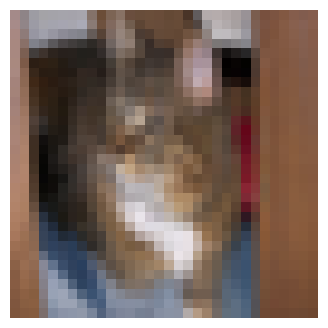

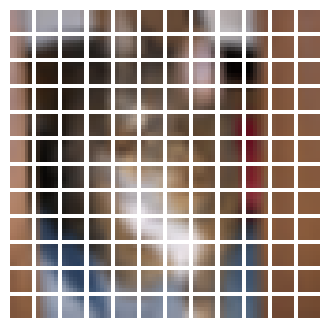

In [9]:
# Visualizing the patches 
plt.figure(figsize = (4,4)) 
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off') 

resized_image = tf.image.resize(
            tf.convert_to_tensor([image]) , size=(image_size , image_size) 
)
patches = CreatePatches(patch_size = patch_size )(resized_image) 
print(f'Image Size {image_size} x {image_size}')
print(f'Patch Size {patch_size} x {patch_size}')
print(f'No. of Patches per Image {patches.shape[1]}')
print(f'Elements in 1 Patch {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4)) 
for i , patch in enumerate(patches[0]) : 
    ax = plt.subplot(n , n ,  i+1)
    patch_img = tf.reshape(patch , (patch_size , patch_size ,3 ))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off') 

In [10]:
class PatchEncoder(layers.Layer) : 
    def __init__(self , n_patches , projection_dim ) : 
        super(PatchEncoder , self ).__init__()
        self.n_patches = n_patches 
        self.projection_dim = projection_dim 
        self.projection = layers.Dense(units = self.projection_dim) 
        self.embedding = layers.Embedding(input_dim = self.n_patches , 
                                         output_dim = self.projection_dim)
    
    def call(self , patch ):
        position = tf.range(0 , self.n_patches , delta = 1 ) 
        encoded  =  self.projection(patch) + self.embedding(position) 
        return encoded 

In [11]:
def create_ViT_Classifier():
    inputs = layers.Input(shape = input_shape )
    augmented_data = data_augmentation(inputs) # augmentation 
    patches = CreatePatches(patch_size)(augmented_data)
    encoded = PatchEncoder(n_patches  , projection_dim )(patches) 
    
    # create multiples layers of transformer block 
    for _ in range(transformer_layers) : 
        # layer normalization 
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attention_output = layers.MultiHeadAttention( # self attention 
                    num_heads = num_heads , 
                    key_dim = projection_dim , 
                    dropout = 0.1 
        )(x1,x1)
        # Skip Connection 1
        x2 = layers.Add()([attention_output , encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6) (x2) 
        # MLP 
        x3 = mlp(x3 , transformer_units , 0.1  )
        enocoded = layers.Add()([x3 , x2] )
        
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
    representation = layers.Flatten()(representation) 
    representation = layers.Dropout(0.5)(representation) 
    features = mlp(representation , mlp_head_units , 0.5 ) 
    # Classify 
    logits = layers.Dense(num_classes )(features)
    
    model = keras.Model(inputs=inputs , outputs= logits) 
    return model 

In [12]:
ViT = create_ViT_Classifier()
ViT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmenter (Sequential)  (None, 72, 72, 3)        7         
                                                                 
 create_patches_1 (CreatePat  (None, None, 108)        0         
 ches)                                                           
                                                                 
 patch_encoder (PatchEncoder  (None, 144, 64)          16192     
 )                                                               
                                                                 
 layer_normalization_16 (Lay  (None, 144, 64)          128       
 erNormalization)                                                
                                                             

In [21]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate , 
                                    weight_decay = weight_decay)
    checkpoint_filepath = './temp/checkpoint'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath ,
                                                           monitor = 'val_accuracy' , 
                                                           save_best_only = True , 
                                                           save_weights_only=True )
    model.compile(optimizer ,
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name="Accuracy") ,
                            keras.metrics.SparseTopKCategoricalAccuracy(5 , name="Top5Accuracy")] )
    history = model.fit(x = x_train , y = y_train ,
                       batch_size = batch_size , 
                       epochs = n_epochs , 
                       validation_split=0.1 ,
                       callbacks = [checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _ , accuracy , top5accuracy = model.evaluate(x_test ,y_test)
    print(f'Test Accuracy  : {round(accuracy * 100 , 2)} %' ) 
    print(f'Top 5 Test Accuracy  : {round(top5accuracy * 100 , 2)} %')
    
    return history , model 


In [22]:
history , ViT = run_experiment(ViT)

Epoch 1/40
176/176 [==============================] - 108s 601ms/step - loss: 2.2221 - Accuracy: 0.2898 - Top5Accuracy: 0.7856 - val_loss: 1.6488 - val_Accuracy: 0.4132 - val_Top5Accuracy: 0.8842
Epoch 2/40
176/176 [==============================] - 106s 601ms/step - loss: 1.7676 - Accuracy: 0.3684 - Top5Accuracy: 0.8565 - val_loss: 1.5479 - val_Accuracy: 0.4562 - val_Top5Accuracy: 0.9052
Epoch 3/40
176/176 [==============================] - 106s 603ms/step - loss: 1.6727 - Accuracy: 0.4035 - Top5Accuracy: 0.8772 - val_loss: 1.4756 - val_Accuracy: 0.4732 - val_Top5Accuracy: 0.9174
Epoch 4/40
176/176 [==============================] - 105s 600ms/step - loss: 1.6164 - Accuracy: 0.4202 - Top5Accuracy: 0.8871 - val_loss: 1.4146 - val_Accuracy: 0.4954 - val_Top5Accuracy: 0.9244
Epoch 5/40
176/176 [==============================] - 102s 582ms/step - loss: 1.5748 - Accuracy: 0.4340 - Top5Accuracy: 0.8978 - val_loss: 1.3967 - val_Accuracy: 0.4940 - val_Top5Accuracy: 0.9252
Epoch 6/40
176/176 [

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./temp/checkpoint

In [ ]:

def plot_metrics(history):
    # Plotting accuracy and top-5 accuracy
    plt.figure(figsize=(12, 6))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Top-5 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['top_k_categorical_accuracy'], label='Train Top-5 Accuracy')
    plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting loss
    plt.figure(figsize=(12, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` is the history object from model training
# Replace `history` with your actual history object
plot_metrics(history)
